### Create Standard Code for Creating Modeling Datasets

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.preprocessing import StandardScaler
#!pip install hbdscan
from sklearn.cluster import DBSCAN
import pickle
from sklearn import metrics
%matplotlib inline
plt.rcParams['font.size'] = 14

In [2]:
sample_n = 2

# filename = 'DE1_0_2008_to_2010_Carrier_Claims_Sample_{}A.zip'.format(sample_n)
# filename = 'DE1_0_2008_to_2010_Carrier_Claims_Sample_{}B.zip'.format(sample_n)
filename = 'DE1_0_2008_to_2010_Inpatient_Claims_Sample_{}.zip'.format(sample_n)
# filename = 'DE1_0_2008_to_2010_Outpatient_Claims_Sample_{}.zip'.format(sample_n)
# filename = 'DE1_0_2008_Beneficiary_Summary_File_Sample_{}.zip'.format(sample_n)
# filename = 'DE1_0_2009_Beneficiary_Summary_File_Sample_{}.zip'.format(sample_n)
# filename = 'DE1_0_2010_Beneficiary_Summary_File_Sample_{}.zip'.format(sample_n)
# filename = 'DE1_0_2008_to_2010_Prescription_Drug_Events_Sample_{}.zip'.format(sample_n)

summary_file_list = ['DE1_0_2008_Beneficiary_Summary_File_Sample_{}.zip'.format(sample_n),
                     'DE1_0_2009_Beneficiary_Summary_File_Sample_{}.zip'.format(sample_n),
                     'DE1_0_2010_Beneficiary_Summary_File_Sample_{}.zip'.format(sample_n)]

df = pd.read_csv('synthetic_data/'+ filename , compression='zip')

In [3]:
## MW: fix
# iter_csv = pd.read_csv('synthetic_data/'+ filename , compression='zip', iterator = True, chunksize = 100000)
# df = pd.concat([chunk[chunk[]]])

pd.read_csv('synthetic_data/DE1_0_2008_to_2010_Prescription_Drug_Events_Sample_{}.zip'.format(sample_n), compression='zip', nrows=10) 

,DESYNPUF_ID,PDE_ID,SRVC_DT,PROD_SRVC_ID,QTY_DSPNSD_NUM,DAYS_SUPLY_NUM,PTNT_PAY_AMT,TOT_RX_CST_AMT
0,00000B48BCF4AD29,83224466404678,20100207,185010401,30.0,30,0.0,10.0
1,00000B48BCF4AD29,83654467130740,20100312,115163303,100.0,30,0.0,30.0
2,00000B48BCF4AD29,83574462630098,20100421,117193205,20.0,20,0.0,160.0
3,00000B48BCF4AD29,83734462622581,20100427,19458016707,30.0,30,10.0,0.0
4,00000B48BCF4AD29,83594462991534,20100611,59746011109,30.0,30,0.0,0.0
5,0000525AB30E4DEF,83794463089433,20080113,367228196,30.0,30,30.0,70.0
6,0000525AB30E4DEF,83774462604852,20080115,49483000510,40.0,0,0.0,10.0
7,0000525AB30E4DEF,83474466939585,20080128,59628075200,30.0,30,10.0,30.0
8,0000525AB30E4DEF,83614462112487,20080214,63629174202,50.0,10,0.0,10.0
9,0000525AB30E4DEF,83074464673935,20080220,63739019515,30.0,30,10.0,10.0


In [4]:
df.head()

,DESYNPUF_ID,CLM_ID,SEGMENT,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,...,HCPCS_CD_36,HCPCS_CD_37,HCPCS_CD_38,HCPCS_CD_39,HCPCS_CD_40,HCPCS_CD_41,HCPCS_CD_42,HCPCS_CD_43,HCPCS_CD_44,HCPCS_CD_45
0,00000B48BCF4AD29,45461150060934,1,20080707.0,20080718.0,1000GD,57000.0,0.0,1.219278e+09,7.451661e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000B48BCF4AD29,45541150055035,1,20080724.0,20080726.0,1030RD,0.0,0.0,9.812675e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00000B48BCF4AD29,45731150068478,1,20080805.0,20080820.0,1001NA,24000.0,0.0,6.035410e+09,9.404475e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000525AB30E4DEF,45811150057351,1,20080525.0,20080605.0,3900MB,4000.0,0.0,1.511429e+09,7.340276e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000525AB30E4DEF,45391150058019,1,20080918.0,20080924.0,3100JN,8000.0,0.0,3.198318e+09,9.156656e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Functions

In [4]:
## helper functions
def grouping_helper(x, keep_list):
    if x in keep_list:
        x = re.sub('[^A-Za-z0-9]+','',x).lower()
    else:
        x = 'Other'
    return x

def join_codes(row):
    return " ".join(list(set([str(v) for i, v in row.iteritems() if pd.notnull(v)])))

In [5]:
# clean and create core dataset
def create_inpatient_core_df(df):
    print(df.columns)
    df.columns = [c.lower() for c in df.columns]
    df = df.loc[(df['clm_from_dt'].notnull() & df['clm_thru_dt'].notnull()),:]

    df['clm_from_datetime'] = [datetime.strptime(str(int(a)),'%Y%m%d') for a in df['clm_from_dt']]
    df['clm_thru_datetime'] = [datetime.strptime(str(int(a)),'%Y%m%d') for a in df['clm_thru_dt']]
    df['clm_start_year'] = df['clm_from_datetime'].dt.year
    df['clm_start_month'] = df['clm_from_datetime'].dt.month

    condition_list = [df['clm_utlztn_day_cnt'] <= 3,
                      (df['clm_utlztn_day_cnt'] > 3) & (df['clm_utlztn_day_cnt'] <= 7),
                      df['clm_utlztn_day_cnt'] > 7]
    choice_list = ['0-3 days', '4-7 days', 'Over 7 days']
    df['clm_utlztn_day_cnt_grouped'] = np.select(condition_list, choice_list, default = 'Other')

    # keep these key columns 
    claims_data_key_cols = ['clm_id','desynpuf_id','segment','clm_start_year',
                           'clm_start_month','clm_from_datetime',
                            'clm_utlztn_day_cnt','clm_utlztn_day_cnt_grouped',
                            'prvdr_num','prvdr_num_grp','at_physn_npi','clm_drg_cd','clm_drg_cd_grp','clm_pmt_amt']

    # group major diagnosis codes
    keep_list = df.clm_drg_cd.value_counts().index[df.clm_drg_cd.value_counts().values > 100]
    df['clm_drg_cd_grp'] = [grouping_helper(r, keep_list) for r in df.clm_drg_cd]
    #df.clm_drg_cd_grp.value_counts()
    keep_list_prvdr = df.prvdr_num.value_counts().index[df.prvdr_num.value_counts().values > 100]
    df['prvdr_num_grp'] = [grouping_helper(r, keep_list_prvdr) for r in df.prvdr_num]


    icd9_dgns_cols = [d for d in df.columns if d[:9] == ('icd9_dgns')]
    icd9_prcdr_cols = [p for p in df.columns if p[:10] == ('icd9_prcdr')]
    hcpcs_cols = [h for h in df.columns if h[:8] == ('hcpcs_cd')]
    provider_cols = [pv for pv in df.columns if 'physn_npi' in pv] 

    collapse_columns_list = [icd9_dgns_cols, icd9_prcdr_cols, 
                             hcpcs_cols, provider_cols]
    suffix_list = ['icd9_dgns','icd9_pcrdr','hcpcs_cd','physn_npi']

    core_df = df.loc[:,claims_data_key_cols]
    i = 0
    for i in range(len(collapse_columns_list)):
        print(suffix_list[i])
        print(collapse_columns_list[i])
        collapsed_codes = df.loc[:, collapse_columns_list[i]].apply(join_codes, axis = 1)
        core_df['collapsed_' + suffix_list[i]] = collapsed_codes
        ## only need to uncomment if using original df as core_df
        #df.drop(columns = collapse_columns_list[i], inplace = True)
    
    return core_df


In [6]:
# create keys master list
def add_summary_info(summary_file_list, df):
    k = pd.DataFrame(columns = ['desynpuf_id','bene_birth_dt', 'bene_sex_ident_cd', 'bene_race_cd'])
    for sf in summary_file_list:
        raw_df = pd.read_csv('synthetic_data/'+ sf , compression='zip')
        f = pd.DataFrame({'desynpuf_id' : raw_df['DESYNPUF_ID'],
                          'bene_birth_dt' : raw_df['BENE_BIRTH_DT'], 
                          'bene_sex_ident_cd' : raw_df['BENE_SEX_IDENT_CD'], 
                          'bene_race_cd' : raw_df['BENE_RACE_CD']})
        k = pd.concat([k, f], axis = 0)

    print(k.shape)
    k.drop_duplicates(inplace = True)
    print(k.shape)
    print(k.head())

    # in a loop, clean each summary data frame and attach to core keys
    for s in summary_file_list:
        raw_df = pd.read_csv('synthetic_data/'+ s , compression='zip')
        # year specific column
        year_specific = raw_df[['SP_STATE_CODE', 'BENE_COUNTY_CD', 
                                'BENE_DEATH_DT', 'BENE_ESRD_IND',
                                'BENE_HI_CVRAGE_TOT_MONS', 'BENE_SMI_CVRAGE_TOT_MONS',
                                'BENE_HMO_CVRAGE_TOT_MONS', 'PLAN_CVRG_MOS_NUM',
                                'MEDREIMB_IP', 'BENRES_IP', 'PPPYMT_IP', 'MEDREIMB_OP', 'BENRES_OP',
                                'PPPYMT_OP', 'MEDREIMB_CAR', 'BENRES_CAR', 'PPPYMT_CAR']]
        year_specific.columns = [(n + '_' + re.findall('\d{4}', s)[0]).lower() for n in year_specific]
        year_specific['desynpuf_id'] = raw_df['DESYNPUF_ID']

        chronic_condition_cols = [cc for cc in raw_df.columns if ((cc[:3] == ('SP_')) & (cc != 'SP_STATE_CODE'))]
        #new_chronic_condition_cols = [n + '_' + re.findall('\d{4}', s)[0] for n in chronic_condition_cols]
        for col in chronic_condition_cols:
            raw_df[col] = raw_df[col] - 1
        year_specific['chronic_condition_count_'+re.findall('\d{4}', s)[0]] = raw_df[chronic_condition_cols].sum(axis = 1)
        print(s.upper() + ' JOINER SHAPE', year_specific.shape)
        k = k.merge(year_specific, how='left', on='desynpuf_id')
        print(s.upper() + ' NEW K SHAPE', k.shape)
    
    collapsed_st = k.loc[:, [st for st in k.columns if (st[:13] == 'sp_state_code')]].apply(join_codes, axis = 1)
    k['collapsed_states'] = collapsed_st

    collapsed_ct = k.loc[:, [ct for ct in k.columns if (ct[:14] == 'bene_county_cd')]].apply(join_codes, axis = 1)
    k['collapsed_counties'] = collapsed_ct

    ## future improvement - combine columns and change to month and year died?
    k['death_ind_2008'] = np.where(k['bene_death_dt_2008'].isnull() == False, 1, 0)
    k['death_ind_2009'] = np.where(k['bene_death_dt_2009'].isnull() == False, 1, 0)
    k['death_ind_2010'] = np.where(k['bene_death_dt_2010'].isnull() == False, 1, 0)
    
    print('df shape - model df', df.shape)
    print('k shape - shape of keys df', k.shape)
    print('df head - model df', df.head())
    merged_df = df.merge(k, how='left', on='desynpuf_id')
    print('merged df shape - join k to df',merged_df.shape)
    merged_df.drop_duplicates(inplace = True)
    print('merged df shape without dupes', merged_df.shape)
    
    return merged_df

## Create Datasets (with EDA)

In [62]:
model_df = create_inpatient_core_df(df)

Index(['desynpuf_id', 'clm_id', 'segment', 'clm_from_dt', 'clm_thru_dt',
       'prvdr_num', 'clm_pmt_amt', 'nch_prmry_pyr_clm_pd_amt', 'at_physn_npi',
       'op_physn_npi', 'ot_physn_npi', 'clm_admsn_dt', 'admtng_icd9_dgns_cd',
       'clm_pass_thru_per_diem_amt', 'nch_bene_ip_ddctbl_amt',
       'nch_bene_pta_coinsrnc_lblty_am', 'nch_bene_blood_ddctbl_lblty_am',
       'clm_utlztn_day_cnt', 'nch_bene_dschrg_dt', 'clm_drg_cd',
       'icd9_dgns_cd_1', 'icd9_dgns_cd_2', 'icd9_dgns_cd_3', 'icd9_dgns_cd_4',
       'icd9_dgns_cd_5', 'icd9_dgns_cd_6', 'icd9_dgns_cd_7', 'icd9_dgns_cd_8',
       'icd9_dgns_cd_9', 'icd9_dgns_cd_10', 'icd9_prcdr_cd_1',
       'icd9_prcdr_cd_2', 'icd9_prcdr_cd_3', 'icd9_prcdr_cd_4',
       'icd9_prcdr_cd_5', 'icd9_prcdr_cd_6', 'hcpcs_cd_1', 'hcpcs_cd_2',
       'hcpcs_cd_3', 'hcpcs_cd_4', 'hcpcs_cd_5', 'hcpcs_cd_6', 'hcpcs_cd_7',
       'hcpcs_cd_8', 'hcpcs_cd_9', 'hcpcs_cd_10', 'hcpcs_cd_11', 'hcpcs_cd_12',
       'hcpcs_cd_13', 'hcpcs_cd_14', 'hcpcs_cd_15', 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

icd9_dgns
['icd9_dgns_cd_1', 'icd9_dgns_cd_2', 'icd9_dgns_cd_3', 'icd9_dgns_cd_4', 'icd9_dgns_cd_5', 'icd9_dgns_cd_6', 'icd9_dgns_cd_7', 'icd9_dgns_cd_8', 'icd9_dgns_cd_9', 'icd9_dgns_cd_10']
icd9_pcrdr
['icd9_prcdr_cd_1', 'icd9_prcdr_cd_2', 'icd9_prcdr_cd_3', 'icd9_prcdr_cd_4', 'icd9_prcdr_cd_5', 'icd9_prcdr_cd_6']
hcpcs_cd
['hcpcs_cd_1', 'hcpcs_cd_2', 'hcpcs_cd_3', 'hcpcs_cd_4', 'hcpcs_cd_5', 'hcpcs_cd_6', 'hcpcs_cd_7', 'hcpcs_cd_8', 'hcpcs_cd_9', 'hcpcs_cd_10', 'hcpcs_cd_11', 'hcpcs_cd_12', 'hcpcs_cd_13', 'hcpcs_cd_14', 'hcpcs_cd_15', 'hcpcs_cd_16', 'hcpcs_cd_17', 'hcpcs_cd_18', 'hcpcs_cd_19', 'hcpcs_cd_20', 'hcpcs_cd_21', 'hcpcs_cd_22', 'hcpcs_cd_23', 'hcpcs_cd_24', 'hcpcs_cd_25', 'hcpcs_cd_26', 'hcpcs_cd_27', 'hcpcs_cd_28', 'hcpcs_cd_29', 'hcpcs_cd_30', 'hcpcs_cd_31', 'hcpcs_cd_32', 'hcpcs_cd_33', 'hcpcs_cd_34', 'hcpcs_cd_35', 'hcpcs_cd_36', 'hcpcs_cd_37', 'hcpcs_cd_38', 'hcpcs_cd_39', 'hcpcs_cd_40', 'hcpcs_cd_41', 'hcpcs_cd_42', 'hcpcs_cd_43', 'hcpcs_cd_44', 'hcpcs_cd_45']
physn_

In [63]:
model_df.clm_drg_cd_grp.value_counts()

Other    27515
176        279
887        266
175        265
187        264
886        263
884        259
949        257
181        255
163        253
177        252
183        251
947        250
180        248
941        248
876        246
184        246
206        245
168        244
182        244
885        242
203        240
202        239
882        237
166        237
199        236
883        235
200        234
196        233
881        233
         ...  
334        109
658        109
556        108
672        108
387        108
698        108
380        108
348        107
355        106
379        106
345        106
329        105
374        105
671        105
653        105
668        104
372        104
388        104
684        104
623        104
669        104
656        103
357        103
335        102
354        102
697        102
666        102
640        101
617        101
394        101
Name: clm_drg_cd_grp, Length: 226, dtype: int64

Index(['clm_id', 'desynpuf_id', 'segment', 'clm_start_year', 'clm_start_month',
       'clm_from_datetime', 'clm_utlztn_day_cnt', 'clm_utlztn_day_cnt_grouped',
       'prvdr_num', 'prvdr_num_grp', 'at_physn_npi', 'clm_drg_cd',
       'clm_drg_cd_grp', 'clm_pmt_amt', 'collapsed_icd9_dgns',
       'collapsed_icd9_pcrdr', 'collapsed_hcpcs_cd', 'collapsed_physn_npi'],
      dtype='object')


,clm_id,desynpuf_id,segment,clm_start_year,clm_start_month,clm_from_datetime,clm_utlztn_day_cnt,clm_utlztn_day_cnt_grouped,prvdr_num,prvdr_num_grp,at_physn_npi,clm_drg_cd,clm_drg_cd_grp,clm_pmt_amt,collapsed_icd9_dgns,collapsed_icd9_pcrdr,collapsed_hcpcs_cd,collapsed_physn_npi
0,45461150060934,00000B48BCF4AD29,1,2008,7,2008-07-07,11.0,Over 7 days,1000GD,Other,1.219278e+09,281,281,57000.0,41410 42821 2762 3970 4241 2763 5119 2760 7802,3521.0 V451 5601 9971 41071,,7451661427.0 1219278332.0
1,45541150055035,00000B48BCF4AD29,1,2008,7,2008-07-24,2.0,0-3 days,1030RD,Other,9.812675e+09,296,296,0.0,V4582 4263 56400 42823 3051 25060 4280 5119 2859,,,9812675420.0
2,45731150068478,00000B48BCF4AD29,1,2008,8,2008-08-05,15.0,Over 7 days,1001NA,1001na,6.035410e+09,263,263,24000.0,41410 5121 2875 3970 4242 42731 V4581 2800 9971,2749 3615.0 53081 42820 2662 78321,,6035410312.0 9404474617.0
3,45811150057351,0000525AB30E4DEF,1,2008,5,2008-05-25,11.0,Over 7 days,3900MB,Other,1.511429e+09,349,Other,4000.0,V4501 2762 51881 53081 5533 5609 79902 42732 V...,9915.0,,7340276481.0 1511429479.0
4,45391150058019,0000525AB30E4DEF,1,2008,9,2008-09-18,6.0,4-7 days,3100JN,3100jn,3.198318e+09,388,388,8000.0,78550 7837 99591 5579 42731 53550 V4611 4019 5849,3898.0 5579,,9156656040.0 3198317523.0


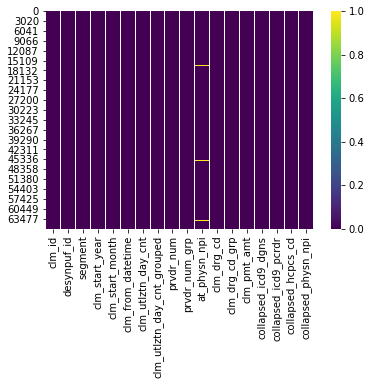

In [64]:
sns.heatmap(model_df.isnull(), cmap = 'viridis')
print(model_df.columns)
model_df.head()

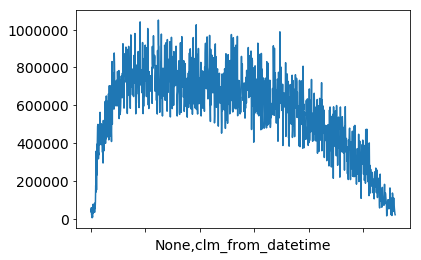

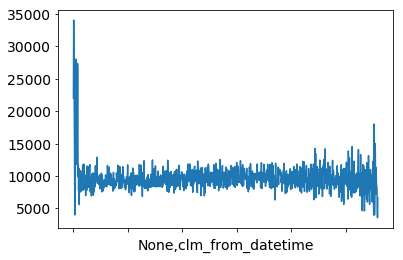

In [13]:
ts_data_temp = model_df.loc[:,['clm_from_datetime','clm_pmt_amt']]
ts_data_temp = ts_data_temp.groupby(['clm_from_datetime']).sum()
ts_data_temp = ts_data_temp.unstack()
ts_data_temp.plot()
plt.show()

ts_data_temp = model_df.loc[:,['clm_from_datetime','clm_pmt_amt']]
ts_data_temp = ts_data_temp.groupby(['clm_from_datetime']).mean()
ts_data_temp = ts_data_temp.unstack()
ts_data_temp.plot()
plt.show()

In [14]:
del ts_data_temp

(343858, 4)
(116395, 4)
        desynpuf_id bene_birth_dt bene_sex_ident_cd bene_race_cd
0  00000B48BCF4AD29      19230901                 2            5
1  0000525AB30E4DEF      19201001                 2            1
2  00009C897C3D8372      19320101                 1            1
3  0001168CE43BE51B      19340901                 2            1
4  0002E494BC87CE10      19140701                 1            2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


DE1_0_2008_BENEFICIARY_SUMMARY_FILE_SAMPLE_2.ZIP JOINER SHAPE (116395, 19)
DE1_0_2008_BENEFICIARY_SUMMARY_FILE_SAMPLE_2.ZIP NEW K SHAPE (116395, 22)
DE1_0_2009_BENEFICIARY_SUMMARY_FILE_SAMPLE_2.ZIP JOINER SHAPE (114618, 19)
DE1_0_2009_BENEFICIARY_SUMMARY_FILE_SAMPLE_2.ZIP NEW K SHAPE (116395, 40)
DE1_0_2010_BENEFICIARY_SUMMARY_FILE_SAMPLE_2.ZIP JOINER SHAPE (112845, 19)
DE1_0_2010_BENEFICIARY_SUMMARY_FILE_SAMPLE_2.ZIP NEW K SHAPE (116395, 58)
df shape - model df (66434, 18)
k shape - shape of keys df (116395, 63)
df head - model df            clm_id       desynpuf_id  segment  clm_start_year  clm_start_month  \
0  45461150060934  00000B48BCF4AD29        1            2008                7   
1  45541150055035  00000B48BCF4AD29        1            2008                7   
2  45731150068478  00000B48BCF4AD29        1            2008                8   
3  45811150057351  0000525AB30E4DEF        1            2008                5   
4  45391150058019  0000525AB30E4DEF        1            2

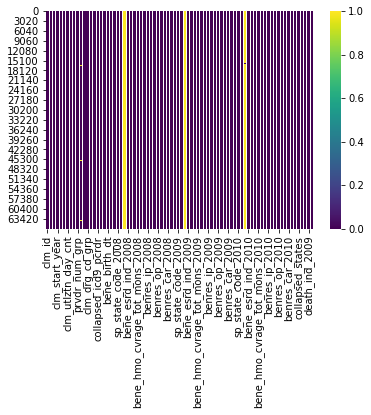

In [65]:
model_df = add_summary_info(summary_file_list, model_df)
sns.heatmap(model_df.isnull(), cmap = 'viridis')

In [42]:
print(model_df.columns)
model_df.head()


Index(['clm_id', 'desynpuf_id', 'segment', 'clm_start_year', 'clm_start_year',
       'clm_start_month', 'clm_from_datetime', 'clm_utlztn_day_cnt',
       'clm_utlztn_day_cnt_grouped', 'prvdr_num', 'prvdr_num_grp',
       'at_physn_npi', 'clm_drg_cd', 'clm_drg_cd_grp', 'clm_pmt_amt',
       'collapsed_icd9_dgns', 'collapsed_icd9_pcrdr', 'collapsed_hcpcs_cd',
       'collapsed_physn_npi', 'bene_birth_dt', 'bene_sex_ident_cd',
       'bene_race_cd', 'sp_state_code_2008', 'bene_county_cd_2008',
       'bene_death_dt_2008', 'bene_esrd_ind_2008',
       'bene_hi_cvrage_tot_mons_2008', 'bene_smi_cvrage_tot_mons_2008',
       'bene_hmo_cvrage_tot_mons_2008', 'plan_cvrg_mos_num_2008',
       'medreimb_ip_2008', 'benres_ip_2008', 'pppymt_ip_2008',
       'medreimb_op_2008', 'benres_op_2008', 'pppymt_op_2008',
       'medreimb_car_2008', 'benres_car_2008', 'pppymt_car_2008',
       'chronic_condition_count_2008', 'sp_state_code_2009',
       'bene_county_cd_2009', 'bene_death_dt_2009', 'bene_esr

,clm_id,desynpuf_id,segment,clm_start_year,clm_start_year,clm_start_month,clm_from_datetime,clm_utlztn_day_cnt,clm_utlztn_day_cnt_grouped,prvdr_num,...,pppymt_op_2010,medreimb_car_2010,benres_car_2010,pppymt_car_2010,chronic_condition_count_2010,collapsed_states,collapsed_counties,death_ind_2008,death_ind_2009,death_ind_2010
0,45461150060934,00000B48BCF4AD29,1,2008,2008,7,2008-07-07,11.0,Over 7 days,1000GD,...,0.0,3800.0,1460.0,0.0,8.0,10.0,260.0,0,0,0
1,45541150055035,00000B48BCF4AD29,1,2008,2008,7,2008-07-24,2.0,0-3 days,1030RD,...,0.0,3800.0,1460.0,0.0,8.0,10.0,260.0,0,0,0
2,45731150068478,00000B48BCF4AD29,1,2008,2008,8,2008-08-05,15.0,Over 7 days,1001NA,...,0.0,3800.0,1460.0,0.0,8.0,10.0,260.0,0,0,0
3,45811150057351,0000525AB30E4DEF,1,2008,2008,5,2008-05-25,11.0,Over 7 days,3900MB,...,0.0,440.0,60.0,0.0,10.0,31.0,300.0,0,0,0
4,45391150058019,0000525AB30E4DEF,1,2008,2008,9,2008-09-18,6.0,4-7 days,3100JN,...,0.0,440.0,60.0,0.0,10.0,31.0,300.0,0,0,0


In [69]:
# no changes over the three year period, so no need to actually treat as collapsed
print(model_df['collapsed_states'].value_counts())
model_df['collapsed_counties'].value_counts()

5.0     5172
10.0    4735
45.0    4431
33.0    4145
14.0    3026
39.0    2902
36.0    2768
23.0    2601
34.0    2202
31.0    2077
11.0    1855
49.0    1753
15.0    1704
44.0    1627
26.0    1606
22.0    1575
1.0     1339
21.0    1322
52.0    1279
18.0    1232
42.0    1195
50.0    1135
24.0    1039
37.0    1017
19.0    1017
3.0      986
25.0     907
7.0      828
4.0      823
17.0     763
16.0     730
6.0      699
38.0     616
51.0     566
28.0     459
29.0     447
54.0     441
32.0     368
46.0     349
20.0     329
30.0     323
13.0     311
41.0     253
8.0      253
27.0     220
12.0     205
43.0     203
35.0     169
47.0     136
53.0     120
9.0      100
2.0       76
Name: collapsed_states, dtype: int64


10.0     1721
200.0    1664
20.0     1598
0.0      1424
90.0     1309
60.0     1291
470.0    1275
150.0    1222
400.0    1211
141.0    1150
170.0    1103
120.0    1083
160.0    1076
250.0    1063
50.0     1035
310.0    1034
620.0    1028
490.0    1021
610.0    1014
40.0      990
480.0     953
290.0     936
130.0     921
390.0     902
590.0     854
240.0     815
440.0     802
30.0      802
510.0     799
100.0     795
         ... 
867.0       2
722.0       2
391.0       2
862.0       2
583.0       2
25.0        2
691.0       2
343.0       1
131.0       1
893.0       1
412.0       1
904.0       1
671.0       1
703.0       1
328.0       1
312.0       1
14.0        1
362.0       1
886.0       1
797.0       1
224.0       1
903.0       1
851.0       1
753.0       1
932.0       1
759.0       1
822.0       1
211.0       1
521.0       1
755.0       1
Name: collapsed_counties, Length: 298, dtype: int64

In [14]:
for m in model_df.dtypes.index[model_df.dtypes == 'object']:
    if m not in ['desynpuf_id', 'bene_birth_dt','prvdr_num','clm_drg_cd','collapsed_icd9_dgns','collapsed_icd9_pcrdr','collapsed_physn_npi']:
        print(m)
        print(model_df[m].value_counts())

clm_utlztn_day_cnt_grouped
0-3 days       30602
4-7 days       22157
Over 7 days    13675
Name: clm_utlztn_day_cnt_grouped, dtype: int64
clm_drg_cd_grp
Other    27515
176        279
887        266
175        265
187        264
886        263
884        259
949        257
181        255
163        253
177        252
183        251
947        250
941        248
180        248
184        246
876        246
206        245
182        244
168        244
885        242
203        240
202        239
882        237
166        237
199        236
883        235
200        234
196        233
881        233
         ...  
658        109
334        109
380        108
387        108
698        108
672        108
556        108
348        107
345        106
355        106
379        106
329        105
374        105
671        105
653        105
623        104
669        104
372        104
388        104
684        104
668        104
357        103
656        103
697        102
335        102
666     

In [15]:
c = model_df.dtypes.index[model_df.dtypes != 'object'].sort_values()
yoy_cols = [st for st in c if re.findall('\d{4}', st) != []]
other_num_cols = [st for st in c if re.findall('\d{4}', st) == []]

In [16]:
## groups year columns together so we can see changes over time
n = 0
while n < len(yoy_cols):
    cols = yoy_cols[n:(n+3)]
    print(model_df.loc[:,cols].describe())
    n = n + 3

       bene_county_cd_2008  bene_county_cd_2009  bene_county_cd_2010
count         66434.000000         66250.000000         65678.000000
mean            378.347352           378.329947           378.200630
std             267.952670           267.894280           267.815066
min               0.000000             0.000000             0.000000
25%             150.000000           150.000000           150.000000
50%             341.000000           341.000000           340.000000
75%             570.000000           570.000000           570.000000
max             999.000000           999.000000           999.000000
       bene_death_dt_2008  bene_death_dt_2009  bene_death_dt_2010
count        1.840000e+02        5.720000e+02        9.660000e+02
mean         2.008088e+07        2.009069e+07        2.010067e+07
std          2.099310e+02        3.482625e+02        3.422066e+02
min          2.008020e+07        2.009010e+07        2.010010e+07
25%          2.008070e+07        2.009040e+07    

In [17]:
n = 0
while n < len(other_num_cols):
    cols = other_num_cols[n:(n+3)]
    print(model_df.loc[:,cols].describe())
    n = n + 3

       at_physn_npi        clm_id
count  6.582200e+04  6.643400e+04
mean   5.057975e+09  4.549849e+13
std    2.914929e+09  2.847276e+11
min    2.977760e+05  4.501115e+13
25%    2.482526e+09  4.525115e+13
50%    4.986923e+09  4.550115e+13
75%    7.668307e+09  4.574115e+13
max    9.999956e+09  4.599115e+13
        clm_pmt_amt  clm_start_month  clm_start_year  clm_start_year
count  66434.000000     66434.000000    66434.000000    66434.000000
mean    9523.033838         6.277554     2008.784086     2008.784086
std     9184.010360         3.356556        0.763096        0.763096
min   -10000.000000         1.000000     2007.000000     2007.000000
25%     4000.000000         3.000000     2008.000000     2008.000000
50%     7000.000000         6.000000     2009.000000     2009.000000
75%    11000.000000         9.000000     2009.000000     2009.000000
max    57000.000000        12.000000     2010.000000     2010.000000
       clm_start_year  clm_start_year  clm_utlztn_day_cnt  segment
count 

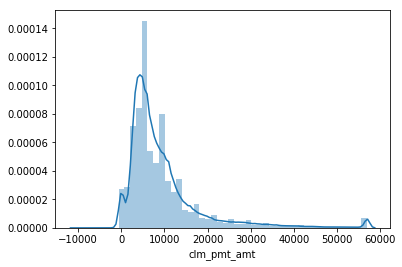

In [66]:
sns.distplot(model_df.clm_pmt_amt)

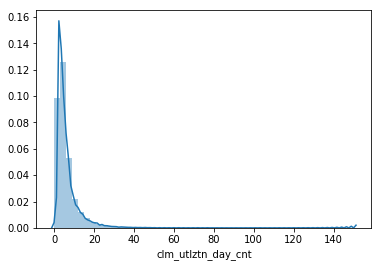

In [67]:
sns.distplot(model_df.clm_utlztn_day_cnt)

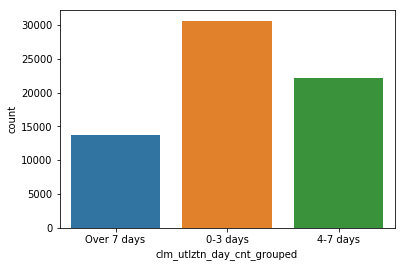

In [68]:
sns.countplot(model_df.clm_utlztn_day_cnt_grouped)

In [69]:
model_df.columns

Index(['clm_id', 'desynpuf_id', 'segment', 'clm_start_year', 'clm_start_month',
       'clm_from_datetime', 'clm_utlztn_day_cnt', 'clm_utlztn_day_cnt_grouped',
       'prvdr_num', 'prvdr_num_grp', 'at_physn_npi', 'clm_drg_cd',
       'clm_drg_cd_grp', 'clm_pmt_amt', 'collapsed_icd9_dgns',
       'collapsed_icd9_pcrdr', 'collapsed_hcpcs_cd', 'collapsed_physn_npi',
       'bene_birth_dt', 'bene_sex_ident_cd', 'bene_race_cd',
       'sp_state_code_2008', 'bene_county_cd_2008', 'bene_death_dt_2008',
       'bene_esrd_ind_2008', 'bene_hi_cvrage_tot_mons_2008',
       'bene_smi_cvrage_tot_mons_2008', 'bene_hmo_cvrage_tot_mons_2008',
       'plan_cvrg_mos_num_2008', 'medreimb_ip_2008', 'benres_ip_2008',
       'pppymt_ip_2008', 'medreimb_op_2008', 'benres_op_2008',
       'pppymt_op_2008', 'medreimb_car_2008', 'benres_car_2008',
       'pppymt_car_2008', 'chronic_condition_count_2008', 'sp_state_code_2009',
       'bene_county_cd_2009', 'bene_death_dt_2009', 'bene_esrd_ind_2009',
       'bene

In [22]:
model_df.head()

,clm_id,desynpuf_id,segment,clm_start_year,clm_start_year,clm_start_month,clm_from_datetime,clm_utlztn_day_cnt,clm_utlztn_day_cnt_grouped,prvdr_num,...,medreimb_ip_2010,benres_ip_2010,pppymt_ip_2010,medreimb_op_2010,benres_op_2010,pppymt_op_2010,medreimb_car_2010,benres_car_2010,pppymt_car_2010,chronic_condition_count_2010
0,45461150060934,00000B48BCF4AD29,1,2008,2008,7,2008-07-07,11.0,Over 7 days,1000GD,...,0.0,0.0,0.0,600.0,30.0,0.0,3800.0,1460.0,0.0,8.0
1,45541150055035,00000B48BCF4AD29,1,2008,2008,7,2008-07-24,2.0,0-3 days,1030RD,...,0.0,0.0,0.0,600.0,30.0,0.0,3800.0,1460.0,0.0,8.0
2,45731150068478,00000B48BCF4AD29,1,2008,2008,8,2008-08-05,15.0,Over 7 days,1001NA,...,0.0,0.0,0.0,600.0,30.0,0.0,3800.0,1460.0,0.0,8.0
3,45811150057351,0000525AB30E4DEF,1,2008,2008,5,2008-05-25,11.0,Over 7 days,3900MB,...,0.0,0.0,0.0,240.0,190.0,0.0,440.0,60.0,0.0,10.0
4,45391150058019,0000525AB30E4DEF,1,2008,2008,9,2008-09-18,6.0,4-7 days,3100JN,...,0.0,0.0,0.0,240.0,190.0,0.0,440.0,60.0,0.0,10.0


In [15]:
model_df.groupby('clm_utlztn_day_cnt_grouped')['clm_pmt_amt'].mean()


clm_utlztn_day_cnt_grouped
0-3 days        7285.117313
4-7 days        9228.373877
Over 7 days    15008.481901
Name: clm_pmt_amt, dtype: float64

clm_utlztn_day_cnt_grouped
0-3 days        7285.117313
4-7 days        9228.373877
Over 7 days    15008.481901
Name: clm_pmt_amt, dtype: float64


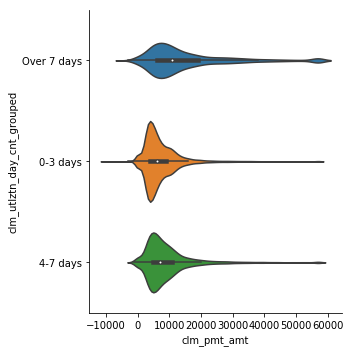

In [21]:
print(model_df.groupby('clm_utlztn_day_cnt_grouped')['clm_pmt_amt'].mean())
sns.catplot(x = 'clm_pmt_amt',
            y = 'clm_utlztn_day_cnt_grouped',
            kind = 'violin', #inner = 'stick',
           data = model_df[['clm_utlztn_day_cnt_grouped','clm_pmt_amt']])

# sns.catplot(x = 'clm_utlztn_day_cnt',
#             y = 'clm_utlztn_day_cnt_grouped',
#              kind = 'violin', #inner = 'stick',
#            data = model_df)

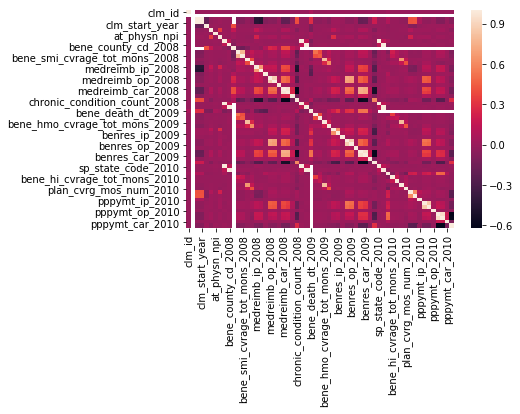

In [22]:
sns.heatmap(model_df.corr())

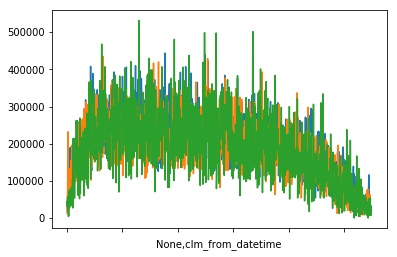

In [23]:
for level in model_df.clm_utlztn_day_cnt_grouped.value_counts().index:
    ts_data_temp = model_df.loc[model_df['clm_utlztn_day_cnt_grouped']== level,['clm_from_datetime','clm_pmt_amt']]
    ts_data_temp = ts_data_temp.groupby(['clm_from_datetime']).sum()
    ts_data_temp = ts_data_temp.unstack()
    ts_data_temp.plot()
plt.show()

In [72]:
model_df.bene_esrd_ind_2008[1:10]

1    0
2    0
3    0
4    0
5    Y
6    Y
7    Y
8    Y
9    Y
Name: bene_esrd_ind_2008, dtype: object

## Clustering

In [7]:
## quickly create datasets for clustering
model_df = create_inpatient_core_df(df)
model_df = add_summary_info(summary_file_list, model_df)

Index(['DESYNPUF_ID', 'CLM_ID', 'SEGMENT', 'CLM_FROM_DT', 'CLM_THRU_DT',
       'PRVDR_NUM', 'CLM_PMT_AMT', 'NCH_PRMRY_PYR_CLM_PD_AMT', 'AT_PHYSN_NPI',
       'OP_PHYSN_NPI', 'OT_PHYSN_NPI', 'CLM_ADMSN_DT', 'ADMTNG_ICD9_DGNS_CD',
       'CLM_PASS_THRU_PER_DIEM_AMT', 'NCH_BENE_IP_DDCTBL_AMT',
       'NCH_BENE_PTA_COINSRNC_LBLTY_AM', 'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM',
       'CLM_UTLZTN_DAY_CNT', 'NCH_BENE_DSCHRG_DT', 'CLM_DRG_CD',
       'ICD9_DGNS_CD_1', 'ICD9_DGNS_CD_2', 'ICD9_DGNS_CD_3', 'ICD9_DGNS_CD_4',
       'ICD9_DGNS_CD_5', 'ICD9_DGNS_CD_6', 'ICD9_DGNS_CD_7', 'ICD9_DGNS_CD_8',
       'ICD9_DGNS_CD_9', 'ICD9_DGNS_CD_10', 'ICD9_PRCDR_CD_1',
       'ICD9_PRCDR_CD_2', 'ICD9_PRCDR_CD_3', 'ICD9_PRCDR_CD_4',
       'ICD9_PRCDR_CD_5', 'ICD9_PRCDR_CD_6', 'HCPCS_CD_1', 'HCPCS_CD_2',
       'HCPCS_CD_3', 'HCPCS_CD_4', 'HCPCS_CD_5', 'HCPCS_CD_6', 'HCPCS_CD_7',
       'HCPCS_CD_8', 'HCPCS_CD_9', 'HCPCS_CD_10', 'HCPCS_CD_11', 'HCPCS_CD_12',
       'HCPCS_CD_13', 'HCPCS_CD_14', 'HCPCS_CD_15', 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

icd9_dgns
['icd9_dgns_cd_1', 'icd9_dgns_cd_2', 'icd9_dgns_cd_3', 'icd9_dgns_cd_4', 'icd9_dgns_cd_5', 'icd9_dgns_cd_6', 'icd9_dgns_cd_7', 'icd9_dgns_cd_8', 'icd9_dgns_cd_9', 'icd9_dgns_cd_10']
icd9_pcrdr
['icd9_prcdr_cd_1', 'icd9_prcdr_cd_2', 'icd9_prcdr_cd_3', 'icd9_prcdr_cd_4', 'icd9_prcdr_cd_5', 'icd9_prcdr_cd_6']
hcpcs_cd
['hcpcs_cd_1', 'hcpcs_cd_2', 'hcpcs_cd_3', 'hcpcs_cd_4', 'hcpcs_cd_5', 'hcpcs_cd_6', 'hcpcs_cd_7', 'hcpcs_cd_8', 'hcpcs_cd_9', 'hcpcs_cd_10', 'hcpcs_cd_11', 'hcpcs_cd_12', 'hcpcs_cd_13', 'hcpcs_cd_14', 'hcpcs_cd_15', 'hcpcs_cd_16', 'hcpcs_cd_17', 'hcpcs_cd_18', 'hcpcs_cd_19', 'hcpcs_cd_20', 'hcpcs_cd_21', 'hcpcs_cd_22', 'hcpcs_cd_23', 'hcpcs_cd_24', 'hcpcs_cd_25', 'hcpcs_cd_26', 'hcpcs_cd_27', 'hcpcs_cd_28', 'hcpcs_cd_29', 'hcpcs_cd_30', 'hcpcs_cd_31', 'hcpcs_cd_32', 'hcpcs_cd_33', 'hcpcs_cd_34', 'hcpcs_cd_35', 'hcpcs_cd_36', 'hcpcs_cd_37', 'hcpcs_cd_38', 'hcpcs_cd_39', 'hcpcs_cd_40', 'hcpcs_cd_41', 'hcpcs_cd_42', 'hcpcs_cd_43', 'hcpcs_cd_44', 'hcpcs_cd_45']
physn_

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


DE1_0_2008_BENEFICIARY_SUMMARY_FILE_SAMPLE_2.ZIP JOINER SHAPE (116395, 19)
DE1_0_2008_BENEFICIARY_SUMMARY_FILE_SAMPLE_2.ZIP NEW K SHAPE (116395, 22)
DE1_0_2009_BENEFICIARY_SUMMARY_FILE_SAMPLE_2.ZIP JOINER SHAPE (114618, 19)
DE1_0_2009_BENEFICIARY_SUMMARY_FILE_SAMPLE_2.ZIP NEW K SHAPE (116395, 40)
DE1_0_2010_BENEFICIARY_SUMMARY_FILE_SAMPLE_2.ZIP JOINER SHAPE (112845, 19)
DE1_0_2010_BENEFICIARY_SUMMARY_FILE_SAMPLE_2.ZIP NEW K SHAPE (116395, 58)
df shape - model df (66434, 18)
k shape - shape of keys df (116395, 63)
df head - model df            clm_id       desynpuf_id  segment  clm_start_year  clm_start_month  \
0  45461150060934  00000B48BCF4AD29        1            2008                7   
1  45541150055035  00000B48BCF4AD29        1            2008                7   
2  45731150068478  00000B48BCF4AD29        1            2008                8   
3  45811150057351  0000525AB30E4DEF        1            2008                5   
4  45391150058019  0000525AB30E4DEF        1            2

In [8]:
cluster_cat_cols = ['bene_sex_ident_cd',
                    'bene_race_cd',
                    'clm_start_year', #cat
                    'clm_start_month', #cat
                    'clm_utlztn_day_cnt_grouped', #cat
                    #'prvdr_num', # cat
                    'prvdr_num_grp', # cat
                    #'at_physn_npi', #cat
                    'npi_grp',
                    #'clm_drg_cd', #cat
                    'clm_drg_cd_grp', #cat 
                    'bene_esrd_ind_2008', # cat
                    'bene_esrd_ind_2009', # cat
                    'bene_esrd_ind_2010', # cat
                    'collapsed_states', # cat
                    #'collapsed_counties',
                    'collapsed_counties_grp'] # cat


cluster_num_cols = [ 
                #'clm_id', 
                #'desynpuf_id', 
                #'segment', 
#                 'clm_start_year', #cat
#                 'clm_start_month', #cat
                'clm_utlztn_day_cnt', 
#                 'clm_utlztn_day_cnt_grouped', #cat 
#                 'prvdr_num', # cat
#                 'at_physn_npi', #cat
#                 'clm_drg_cd', #cat
#                 'clm_drg_cd_grp', #cat
                'clm_pmt_amt', 
                #'bene_birth_dt', 
#                 'bene_sex_ident_cd', #cat
#                 'bene_race_cd', #cat
                #'sp_state_code_2008',  
                #'bene_county_cd_2008', 
                #'bene_death_dt_2008',  
#                 'bene_esrd_ind_2008', # cat
                'bene_hi_cvrage_tot_mons_2008', 
                'bene_smi_cvrage_tot_mons_2008', 
                'bene_hmo_cvrage_tot_mons_2008',
                'plan_cvrg_mos_num_2008', 
                'medreimb_ip_2008', 
                'benres_ip_2008',
                'pppymt_ip_2008', 
                'medreimb_op_2008', 
                'benres_op_2008',
                'pppymt_op_2008', 
                'medreimb_car_2008', 
                'benres_car_2008',
                'pppymt_car_2008', 
                'chronic_condition_count_2008', 
                #'sp_state_code_2009', 
                #'bene_county_cd_2009', 
                #'bene_death_dt_2009', 
#                 'bene_esrd_ind_2009', # cat
                'bene_hi_cvrage_tot_mons_2009', 
                'bene_smi_cvrage_tot_mons_2009',
                'bene_hmo_cvrage_tot_mons_2009', 
                'plan_cvrg_mos_num_2009',
                'medreimb_ip_2009', 
                'benres_ip_2009', 
                'pppymt_ip_2009',
                'medreimb_op_2009', 
                'benres_op_2009', 
                'pppymt_op_2009',
                'medreimb_car_2009', 
                'benres_car_2009', 
                'pppymt_car_2009',
                'chronic_condition_count_2009', 
                #'sp_state_code_2010', 
                #'bene_county_cd_2010', 
                #'bene_death_dt_2010', 
#                 'bene_esrd_ind_2010',# cat
                'bene_hi_cvrage_tot_mons_2010', 
                'bene_smi_cvrage_tot_mons_2010',
                'bene_hmo_cvrage_tot_mons_2010', 
                'plan_cvrg_mos_num_2010',
                'medreimb_ip_2010', 
                'benres_ip_2010', 
                'pppymt_ip_2010',
                'medreimb_op_2010', 
                'benres_op_2010', 
                'pppymt_op_2010',
                'medreimb_car_2010', 
                'benres_car_2010', 
                'pppymt_car_2010',
                'chronic_condition_count_2010',
#                 'collapsed_states', # cat
#                 'collapsed_counties', # cat
                'death_ind_2008', 
                'death_ind_2009',
                'death_ind_2010']

cluster_cols_to_expand = ['collapsed_icd9_dgns', ##### to expand
                          'collapsed_icd9_pcrdr', ####
                         #'collapsed_hcpcs_cd', 
                          'collapsed_physn_npi']# cat

In [9]:
#cluster_cat_cols
#model_df.clm_start_year #.value_counts()

In [10]:
def keep_list_int(x, keep_list):
    if x not in keep_list:
        x = 'Other'
    return x

In [106]:
keep_list_cnt = model_df.collapsed_counties.value_counts().index[model_df.collapsed_counties.value_counts().values > 100]
model_df['collapsed_co
         unties_grp'] = [grouping_helper(r, keep_list_cnt) for r in model_df.collapsed_counties]

keep_list_npi = model_df.at_physn_npi.value_counts().index[model_df.at_physn_npi.value_counts().values > 100]
model_df['npi_grp'] = [keep_list_int(n, keep_list_npi) for n in model_df.at_physn_npi]

X = model_df[cluster_num_cols]
X = pd.concat([X, pd.get_dummies(data = model_df[cluster_cat_cols], 
                                 columns = cluster_cat_cols)], axis=1)

In [113]:
X = model_df[cluster_num_cols]

In [100]:
# dict_of_dicts = dict()
# vec = CountVectorizer(min_df = 50, binary = True)

# X = model_df[cluster_num_cols]
# for clst in cluster_cols_to_expand:
# #clst = cluster_cols_to_expand[2]
#     x_temp = vec.fit_transform(model_df.loc[:,clst])
#     print(clst, 'added features:', len(vec.get_feature_names()))
#     x_temp = pd.DataFrame(x_temp.toarray())
#     x_temp.columns = vec.get_feature_names()
#     print(vec.get_feature_names()[1:10])
#     X = pd.concat([X, x_temp], axis=1)

In [114]:
# what do nulls look like
X.isnull().sum()[X.isnull().sum().values > 0]

bene_hi_cvrage_tot_mons_2009     184
bene_smi_cvrage_tot_mons_2009    184
bene_hmo_cvrage_tot_mons_2009    184
plan_cvrg_mos_num_2009           184
medreimb_ip_2009                 184
benres_ip_2009                   184
pppymt_ip_2009                   184
medreimb_op_2009                 184
benres_op_2009                   184
pppymt_op_2009                   184
medreimb_car_2009                184
benres_car_2009                  184
pppymt_car_2009                  184
chronic_condition_count_2009     184
bene_hi_cvrage_tot_mons_2010     756
bene_smi_cvrage_tot_mons_2010    756
bene_hmo_cvrage_tot_mons_2010    756
plan_cvrg_mos_num_2010           756
medreimb_ip_2010                 756
benres_ip_2010                   756
pppymt_ip_2010                   756
medreimb_op_2010                 756
benres_op_2010                   756
pppymt_op_2010                   756
medreimb_car_2010                756
benres_car_2010                  756
pppymt_car_2010                  756
c

In [115]:
#X.fillna(value = -999, inplace = True) # fill nulls 
X.dropna(inplace = True)
X = StandardScaler().fit_transform(X) # scale data

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [116]:
X

array([[ 0.88920769,  5.17252749,  0.1848729 , ...,  0.        ,
         0.        , -0.12217888],
       [-0.5758406 , -1.03770885,  0.1848729 , ...,  0.        ,
         0.        , -0.12217888],
       [ 1.54034026,  1.5771275 ,  0.1848729 , ...,  0.        ,
         0.        , -0.12217888],
       ...,
       [-0.08749117, -0.92875734,  0.1848729 , ...,  0.        ,
         0.        , -0.12217888],
       [-0.73862374, -0.60190279,  0.1848729 , ...,  0.        ,
         0.        , -0.12217888],
       [ 0.5636414 ,  0.0518063 ,  0.1848729 , ...,  0.        ,
         0.        , -0.12217888]])

In [117]:
db = DBSCAN(n_jobs = -1).fit(X)
filename = 'db_numeric.pickle'
pickle.dump(db, open(filename,'wb'))
with open(filename, 'rb') as d:
    db = pickle.load(d)

In [123]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 184
Estimated number of noise points: 64516
Silhouette Coefficient: -0.442


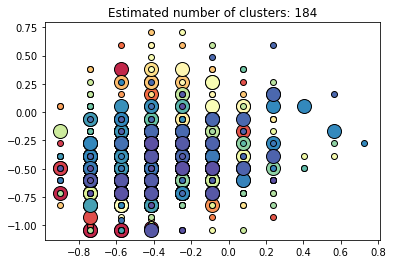

In [122]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k != -1:
        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

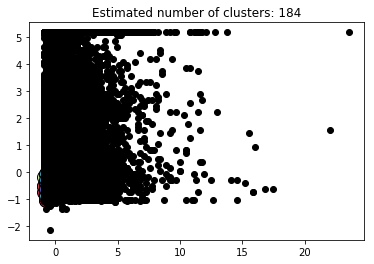

In [126]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0,0,0,1]
    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### Network Analysis

In [127]:
model_df.columns
# network columns: desynpuf_id collapsed_physn_npi clm_pmt_amt clm_utlztn_day_cnt

def make_data_long(src, collapsed_dest, wgt, df):
    df = df.loc[:,[collapsed_dest, src, wgt]]
    x = df.assign(**{collapsed_dest:df[collapsed_dest].str.split(' ')}) 
    x.head()

    df = pd.DataFrame({col:np.repeat(x[col].values, x[collapsed_dest].str.len())
                        for col in x.columns.difference([collapsed_dest])
        }).assign(**{collapsed_dest:np.concatenate(x[collapsed_dest].values)})[x.columns.tolist()]
    
    # for blanks
    df = df[(df[src] != '') & (df[collapsed_dest] != '')]
    return df

df = make_data_long(src = 'desynpuf_id',
                    collapsed_dest = 'collapsed_physn_npi',
                    wgt = 'clm_pmt_amt',
                    df = model_df)

In [128]:
%%time
import networkx as nx
src = 'desynpuf_id'
collapsed_dest = 'collapsed_physn_npi'
wgt = 'clm_pmt_amt'
df = df

G = nx.MultiGraph()
G.add_weighted_edges_from(list(zip(df[src], df[collapsed_dest], df[wgt])))

Wall time: 7.53 s


C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\layout.py:499: RuntimeWarning: invalid value encountered in sqrt
  distance = np.sqrt((delta**2).sum(axis=0))


Wall time: 2h 54min 26s


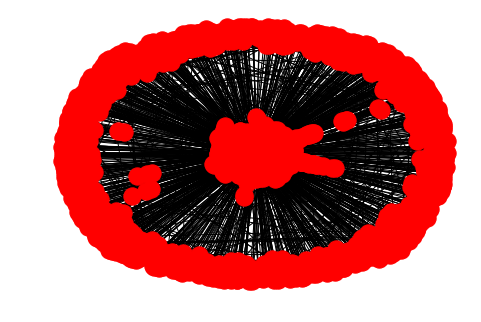

In [61]:
%%time
nx.draw(G)

In [183]:
#print('avg degree connectivity:\n', nx.average_degree_connectivity(G))

In [182]:
# node level
A = nx.average_neighbor_degree(G)

#dict(sorted(A.items(), key=operator.itemgetter(1), reverse=True)[:5])

In [137]:
N, K = G.order(), G.size()
avg_degree = float(K) / N

print("Nodes: ", N)
print("Edges: ", K)
print("Average Connection: ", avg_degree)
print("Assortativity: ", nx.degree_assortativity_coefficient(G))

Nodes:  63938
Edges:  99885
Average Connection:  1.5622165222559354
Assortativity:  -0.12587283742279906


In [148]:
%%time
F = nx.make_max_clique_graph(G)
N, K = F.order(), F.size()
avg_degree = float(K) / N

print("Nodes: ", N)
print("Edges: ", K)
print("Average Connection: ", avg_degree)
print("Assortativity: ", nx.degree_assortativity_coefficient(G))

Nodes:  91864
Edges:  1701204
Average Connection:  18.518723330140208
Assortativity:  -0.12587283742279906
Wall time: 13min 53s


In [172]:
d = dict(F.degree())
values = sorted(set(d.values()))
d_hist = list(d.values())
d_hist = [d_hist.count(r) for r in values]

Text(0.5,1,'Network of Fully Connected Beneficiary/Provider Subgraphs')

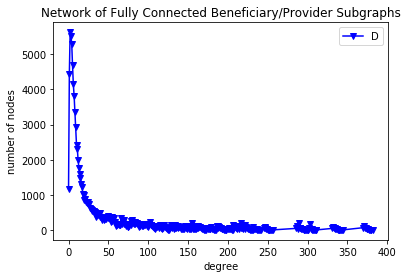

In [175]:
plt.plot(values,d_hist, 'bv-')
plt.legend('Deg')
plt.xlabel('degree')
plt.ylabel('number of nodes')
plt.title('Network of Fully Connected Beneficiary/Provider Subgraphs')

In [ ]:
%%time
nx.draw(G)

             npi       beneficiary  clm_pmt_amt
10  4123724626.0  00009C897C3D8372       9000.0
12  4123724626.0  00009C897C3D8372      10000.0
14  4123724626.0  00009C897C3D8372       7000.0
15  4123724626.0  00009C897C3D8372       7000.0
13  4842645658.0  00009C897C3D8372      10000.0
11  5019745638.0  00009C897C3D8372        100.0


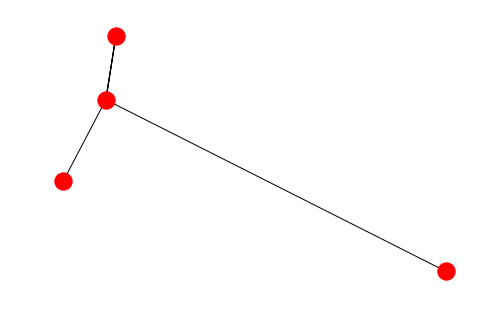

In [84]:
H = nx.MultiGraph()
df_example = df[df[src] == '00009C897C3D8372']
df_example.columns = ['npi','beneficiary','clm_pmt_amt']
print(df_example.sort_values(by='npi'))
H.add_weighted_edges_from(list(zip(df_example['npi'], 
                                   df_example['beneficiary'], 
                                   df_example['clm_pmt_amt'])))
nx.draw(H)
#labs = nx.draw_networkx_labels(G= H, pos = nx.spring_layout(H))
#print(labs)

Complete Network Stuff

Explore feature reduction (T-SNE or PCA) and clustering (k-modes vs. k-means)

Considering using hierarchy/diagnosis group code to reduce the dimensionality of codes